# Clasificación de Texto

Como vimos anteriormente, la **minería de texto** se puede abordar siguiendo las fases del siguiente **pipeline general**:

1. **Preprocesamiento**.
2. **Análisis exploratorio de los datos** (EDA).
3. **Representación del texto**.
4. **Modelamiento**: en este paso, se selecciona un modelo matemático que permita clasificar/agrupar/describir los textos utilizando las representaciones obtenidas en el paso anterior.
5. **Validación y despliegue**: finalmente, se evalúa el desempeño del modelo para posteriormente utilizarlo en la práctica.

<img src="https://res.cloudinary.com/dyd911kmh/image/upload/f_auto,q_auto:best/v1535125878/NLTK3_zwbdgg.png" alt="model" width="600"/>

En este notebbok, estudiaremos las fases finales de **modelamiento** y **validación**. En particular, en el modelamiento veremos cómo construir **modelos de clasificación de texto**. Esta es una tarea de **aprendizaje supervisado** dentro de las técnicas de *machine learning*:

<img src="https://www.mathworks.com/help/stats/machinelearning_supervisedunsupervised.png" width="600">

Para tener un poco de contexto en técnicas de *Machine Learning*:

<img src="https://i.vas3k.ru/7vx.jpg" alt="ML" width="600"/>


## Introducción: Análisis Supervisado de Texto

En general, un problema de clasificación consiste en determinar los parámetros $w$ de un modelo $M$ por medio de un conjunto de datos $\mathbf{X}=\{\vec{x_1},\vec{x_2},\dots,\vec{x_N}\}$ con sus respectivas etiquetas $Y=\{y_1,y_2,\dots,y_n\}$.

Por ejemplo, en el caso de un detector de spam para correo electrónico:

<img src="https://developers.google.com/machine-learning/guides/text-classification/images/TextClassificationExample.png" alt="spam" width="600"/>

In [ ]:
import nltk
import re
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("ggplot")
nltk.download("popular")
nltk.download("wordnet")

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cmudict.zip.
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gazetteers.zip.
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/genesis.zip.
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gutenberg.zip.
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/inaugural.zip.
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/movie_reviews.zip.
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/names.zip.
[nltk_data]    | Downloading package shakespeare to /root/nltk_data...
[nlt

True

In [ ]:
!gdown 16UFo5q6VoVGsxSWBfwQ-0Xsj6IhZZTLb

Downloading...
From: https://drive.google.com/uc?id=16UFo5q6VoVGsxSWBfwQ-0Xsj6IhZZTLb
To: /content/all.json
100% 122k/122k [00:00<00:00, 87.3MB/s]


### Aplicaciones en texto

* Categorías temáticas.
* Identificación de autor.
* Detección de spam.
* Análisis de sentimientos.

### Ejemplo: Clasificación de spam

A manera de aplicación de ejemplo, realizaremos **clasificación automática de spam**. Para ello utilizaremos un dataset con etiquetas de spam en mensajes de SMS. Este conjunto de datos se encuentra disponible en [línea](https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection).

En este punto realizaremos las primeras fases de la minería de texto para preparar los datos para el modelamiento. Primero, cargamos el dataset como un dataframe de `pandas`:

In [ ]:
df = pd.read_csv(
        "spam.csv",
        sep=","
        )

df.columns = [
    "text",
    "label"
    ]
df.head(10)

,text,label
0,date wed NUMBER aug NUMBER NUMBER NUMBER NUMB...,0
1,martin a posted tassos papadopoulos the greek ...,0
2,man threatens explosion in moscow thursday aug...,0
3,klez the virus that won t die already the most...,0
4,in adding cream to spaghetti carbonara which ...,0
5,i just had to jump in here as carbonara is on...,0
6,the scotsman NUMBER august NUMBER playboy want...,0
7,martin adamson wrote isn t it just basically a...,0
8,the scotsman thu NUMBER aug NUMBER meaningful ...,0
9,i have been trying to research via sa mirrors ...,0


In [ ]:
df[df['label']==1].head(5)

,text,label
2500,save up to NUMBER on life insurance why spend...,1
2501,NUMBER fight the risk of cancer URL NUMBER sli...,1
2502,NUMBER fight the risk of cancer URL NUMBER sli...,1
2503,adult club offers free membership instant acc...,1
2504,i thought you might like these NUMBER slim dow...,1


#### Análisis Exploratorio de los Datos

Vamos a realizar una inspección general de este conjunto de datos:

In [ ]:
df.count()

text     2999
label    3000
dtype: int64

Verificamos el número de valores vacíos:

In [ ]:
print(df.isnull().sum())

text     1
label    0
dtype: int64


Borrar valores nulos

In [ ]:
df = df.dropna()

print(df.isnull().sum())

text     0
label    0
dtype: int64


Veamos la cantidad de etiquetas por categoría:

In [ ]:
print(df["label"].value_counts())

0    2500
1     499
Name: label, dtype: int64


Como podemos ver, se trata de un conjunto de datos con un desbalance bastante alto, es decir, debemos utilizar técnicas de machine learning para tratar con este problema.

#### Preparación del Conjunto de Datos

Vamos a añadir algunas columnas al conjunto de datos: longitud del SMS y cantidad de signos de puntuación. Con esto intentaremos clasificar más adelante.

In [ ]:
df['len'] = df["text"].apply(len)
df.head()

,text,label,len
0,date wed NUMBER aug NUMBER NUMBER NUMBER NUMB...,0,1522
1,martin a posted tassos papadopoulos the greek ...,0,643
2,man threatens explosion in moscow thursday aug...,0,1509
3,klez the virus that won t die already the most...,0,1015
4,in adding cream to spaghetti carbonara which ...,0,771


De igual forma, creamos una función para contar los signos de puntuación

In [ ]:
def cont_punt(cadena):
    cont_punt = Counter(
            char
            for char in cadena
            if char in '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'
            )
    return sum(cont_punt.values())

df['punkt'] = df["text"].apply(cont_punt)
df.head()

,text,label,len,punkt
0,date wed NUMBER aug NUMBER NUMBER NUMBER NUMB...,0,1522,51
1,martin a posted tassos papadopoulos the greek ...,0,643,0
2,man threatens explosion in moscow thursday aug...,0,1509,0
3,klez the virus that won t die already the most...,0,1015,47
4,in adding cream to spaghetti carbonara which ...,0,771,0


In [ ]:
corpus = df["text"]
labels = df["label"]

Imprimimos el corpus (los cinco primeros)

In [ ]:
corpus[:5]

0     date wed NUMBER aug NUMBER NUMBER NUMBER NUMB...
1    martin a posted tassos papadopoulos the greek ...
2    man threatens explosion in moscow thursday aug...
3    klez the virus that won t die already the most...
4     in adding cream to spaghetti carbonara which ...
Name: text, dtype: object

Imprimimos las etiquetas (las cinco primeras)

In [ ]:
labels[:5]

0    0
1    0
2    0
3    0
4    0
Name: label, dtype: int64

Ahora, realizaremos el preprocesamiento de los textos con `nltk`:

In [ ]:
wpt = nltk.WordPunctTokenizer()
lem = nltk.WordNetLemmatizer()
sw = nltk.corpus.stopwords.words('english')

Definimos la función de preprocesamiento

In [ ]:
def preprocess(doc):
    doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I|re.A)
    doc = doc.lower().strip()
    tokens = wpt.tokenize(doc)
    tokens = [
            lem.lemmatize(token)
            for token in tokens
            if token not in sw
            ]
    doc = ' '.join(tokens)
    return doc

Veamos el texto luego del preprocesamiento

In [ ]:
norm_corpus = list(
        map(
            preprocess, corpus
            )
        )
norm_corpus[:5]

['date wed number aug number number number number number chris garrigues cwg dated number numberfanumberd deepeddy com message id number number tmda deepeddy vircio com reproduce error repeatable like every time without fail debug log pick happening number number number pickit exec pick inbox list lbrace lbrace subject ftp rbrace rbrace number number sequence mercury number number number exec pick inbox list lbrace lbrace subject ftp rbrace rbrace number number sequence mercury number number number ftocpickmsgs number hit number number number marking number hit number number number tkerror syntax error expression int note run pick command hand delta pick inbox list lbrace lbrace subject ftp rbrace rbrace number number sequence mercury number hit number hit come obviously version nmh using delta pick version pick nmh number number number compiled url sun mar number number number number ict number relevant part mhprofile delta mhparam pick seq sel list since pick command work sequence ac

#### Representación de los Textos

Ahora, cada texto se representará como una bolsa de palabras:

In [ ]:
vectorizer = CountVectorizer()
bow = vectorizer.fit_transform(norm_corpus)
bow

<2999x30582 sparse matrix of type '<class 'numpy.int64'>'
	with 254006 stored elements in Compressed Sparse Row format>

También, vamos a usar la representación TF-IDF. Con la clase `TfidfVectorizer` podremos obtener la representación TF-IDF directamente del texto como se muestra a continuación:

In [ ]:
tf_idf_vect = TfidfVectorizer(
        use_idf=True,
        sublinear_tf=True
        )

Entrenamos y extraemos características

In [ ]:
tf_idf = tf_idf_vect.fit_transform(norm_corpus)
tf_idf

<2999x30582 sparse matrix of type '<class 'numpy.float64'>'
	with 254006 stored elements in Compressed Sparse Row format>

**Realizamos la partición de los datos: 70%/30%.**

Nótese que estamos usando un parámetro ``random_state=0`` para inicializar una semilla para asegurarnos que todos obtengamos los mismos resultados.

Estas son las variables que le pasaremos a nuestros clasificadores para entrenar y validar los modelos: X_train_cols, X_test_cols, y_train_cols, y_test_cols

Ahora, haremos la misma división pero con la bolsa de palabras:

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
        bow, labels, test_size=0.3, random_state=0
        )

print("Observaciones para entrenamiento (70% de 5572): {}".format(X_train.shape[0]))
print("Observaciones para prueba (30% de 5572): {}".format(X_test.shape[0]))

Observaciones para entrenamiento (70% de 5572): 2099
Observaciones para prueba (30% de 5572): 900


Por último, usaremos la representación del texto obtenida con TF-IDF.

In [ ]:
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(
        tf_idf, np.array(labels), test_size=0.3, random_state=0
        )

print("Observaciones para entrenamiento (70% de 5572): {}".format(X_train_tfidf.shape[0]))
print("Observaciones para prueba (30% de 5572): {}".format(X_test_tfidf.shape[0]))

Observaciones para entrenamiento (70% de 5572): 2099
Observaciones para prueba (30% de 5572): 900


### Clasificador: Logistic Regression classifier

Una de las herramientas de clasificación multi-clase más sencilla es el clasificador: [logistic regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html). Scikit-learn ofrece una variedad de algoritmos de ``solvers`` que se utilizan para parametrizar este clasificador, en nuestro caso: [L-BFGS](https://en.wikipedia.org/wiki/Limited-memory_BFGS).

#### Representación de texto: **Bolsa de Palabras - BoW**

Primero, usaremos la representación de **Bolsa de Palabras - BoW**:

In [ ]:
lr_model = LogisticRegression(solver='lbfgs')
lr_model.fit(X_train, y_train)
predictions = lr_model.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
# Matriz de confusión
con_mat = metrics.confusion_matrix(y_test, predictions)
con_mat

array([[752,   0],
       [  8, 140]])

In [ ]:
# Matriz de confusión en un dataframe
df = pd.DataFrame(con_mat, index=['no spam','spam'], columns=['no spam','spam'])
df

,no spam,spam
no spam,752,0
spam,8,140


In [ ]:
print(metrics.accuracy_score(y_test,predictions))

0.9911111111111112


En este caso, el accuracy mejoró un poco más, llegó hasta: **98.1%**  (BoW + LogisticRegression).

#### Representación de texto: **TF-IDF**

A continuación, usaremos la representación obtenida con **TF-IDF** y el clasificador LogisticRegression:

In [ ]:
lr_model = LogisticRegression(solver='lbfgs')
lr_model.fit(X_train_tfidf, y_train_tfidf)
predictions = lr_model.predict(X_test_tfidf)

In [ ]:
# Matriz de confusión
con_mat = metrics.confusion_matrix(y_test_tfidf, predictions)
print(con_mat)

[[752   0]
 [ 44 104]]


In [ ]:
print(metrics.accuracy_score(y_test_tfidf, predictions))

0.9511111111111111


En este caso, bajó un poco el desempeño, el accuracy fue: **95.1%**  (TF-IDF + LogisticRegression).

### Clasificador Naive-Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB

bayes = GaussianNB()
bayes.fit(X_train.toarray(), y_train)

predictions = bayes.predict(X_test.toarray())

In [ ]:
# Matriz de confusión
con_mat = metrics.confusion_matrix(y_test, predictions)
con_mat

array([[726,  26],
       [ 45, 103]])

In [ ]:
# Matriz de confusión en un dataframe
df = pd.DataFrame(con_mat, index=['no spam','spam'], columns=['no spam','spam'])
df

,no spam,spam
no spam,726,26
spam,45,103


In [ ]:
print(metrics.accuracy_score(y_test,predictions))

0.9211111111111111


#### Representación de texto: **TF-IDF**

A continuación, usaremos la representación obtenida con **TF-IDF** y el clasificador LogisticRegression:

In [ ]:
bayes = GaussianNB()
bayes.fit(X_train_tfidf.toarray(), y_train_tfidf)
predictions = bayes.predict(X_test_tfidf.toarray())

In [ ]:
# Matriz de confusión
con_mat = metrics.confusion_matrix(y_test_tfidf, predictions)
print(con_mat)

[[726  26]
 [ 43 105]]


In [ ]:
print(metrics.accuracy_score(y_test_tfidf, predictions))

0.9233333333333333


### Clasificador K-Nearest Neighbors

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {'n_neighbors': list(range(5,100,5))}

clf = GridSearchCV(KNeighborsClassifier(), param_grid=param_grid, verbose=2, cv=5)
clf.fit(X_train.toarray(), y_train)

results_knn = clf.cv_results_['mean_test_score']

Fitting 5 folds for each of 19 candidates, totalling 95 fits
[CV] END ......................................n_neighbors=5; total time=   2.0s
[CV] END ......................................n_neighbors=5; total time=   1.9s
[CV] END ......................................n_neighbors=5; total time=   1.9s
[CV] END ......................................n_neighbors=5; total time=   2.1s
[CV] END ......................................n_neighbors=5; total time=   3.1s
[CV] END .....................................n_neighbors=10; total time=   1.9s
[CV] END .....................................n_neighbors=10; total time=   1.9s
[CV] END .....................................n_neighbors=10; total time=   1.9s
[CV] END .....................................n_neighbors=10; total time=   1.9s
[CV] END .....................................n_neighbors=10; total time=   1.8s
[CV] END .....................................n_neighbors=15; total time=   2.9s
[CV] END .....................................n_

In [ ]:
print(clf.best_params_)

{'n_neighbors': 15}


In [ ]:
# Matriz de confusión
predictions = clf.predict(X_test)

con_mat = metrics.confusion_matrix(y_test, predictions)
con_mat

array([[745,   7],
       [103,  45]])

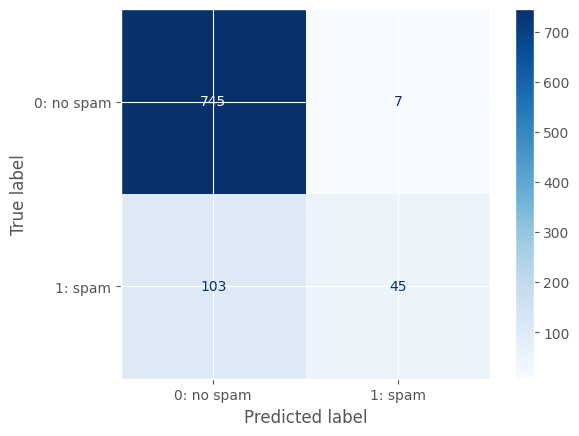

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

cf = ConfusionMatrixDisplay([])
cf.from_predictions(y_test, predictions, display_labels=["0: no spam", "1: spam"], cmap='Blues')

In [ ]:
print(metrics.accuracy_score(y_test,predictions))

0.8777777777777778


#### Representación de texto: **TF-IDF**

A continuación, usaremos la representación obtenida con **TF-IDF** y el clasificador LogisticRegression:

In [ ]:
from sklearn.naive_bayes import GaussianNB

clf = GridSearchCV(KNeighborsClassifier(), param_grid=param_grid, verbose=2, cv=5)
clf.fit(X_train_tfidf.toarray(), y_train_tfidf)

print(clf.best_params_)
predictions = clf.predict(X_test_tfidf.toarray())

Fitting 5 folds for each of 19 candidates, totalling 95 fits
[CV] END ......................................n_neighbors=5; total time=   1.9s
[CV] END ......................................n_neighbors=5; total time=   1.8s
[CV] END ......................................n_neighbors=5; total time=   2.8s
[CV] END ......................................n_neighbors=5; total time=   2.0s
[CV] END ......................................n_neighbors=5; total time=   1.8s
[CV] END .....................................n_neighbors=10; total time=   1.8s
[CV] END .....................................n_neighbors=10; total time=   1.8s
[CV] END .....................................n_neighbors=10; total time=   1.8s
[CV] END .....................................n_neighbors=10; total time=   2.2s
[CV] END .....................................n_neighbors=10; total time=   2.7s
[CV] END .....................................n_neighbors=15; total time=   1.9s
[CV] END .....................................n_

In [ ]:
# Matriz de confusión
con_mat = metrics.confusion_matrix(y_test_tfidf, predictions)
print(con_mat)

[[751   1]
 [  8 140]]


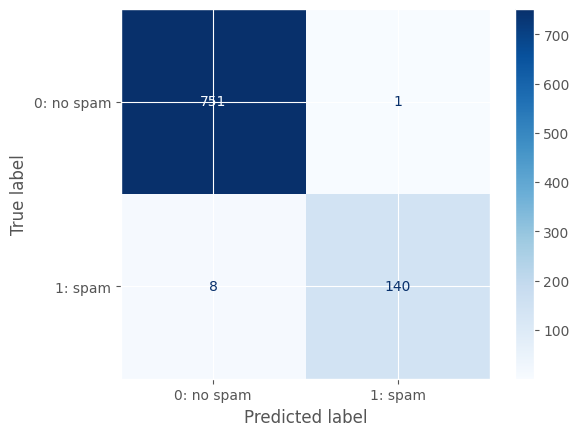

In [ ]:
cf = ConfusionMatrixDisplay([])
cf.from_predictions(y_test, predictions, display_labels=["0: no spam", "1: spam"], cmap='Blues')

In [ ]:
print(metrics.accuracy_score(y_test_tfidf, predictions))

0.99
